In [34]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCPCN
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train import val_pass

In [35]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [36]:
torch.manual_seed(seed)

# Scale img transform
class Scale(object):
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        return img * self.scale_factor + 0.5 * (1 - self.scale_factor)

# Inverse Logistic Sigmoid Transform
class InvLogit(object):
    def __call__(self, x):
        return torch.log(x / (1 - x))

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.FashionMNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

  0%|          | 0/48000 [00:00<?, ?it/s]

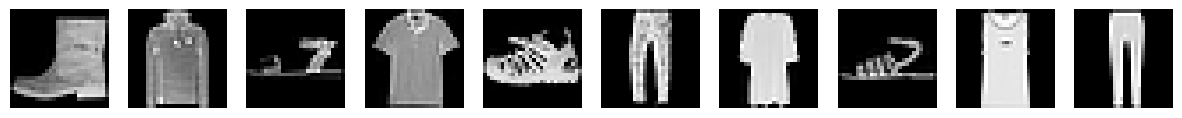

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [37]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [9]:
all_stats = {}

In [29]:
def train(
        model,
        BATCH_SIZE,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        optimiser,
        scheduler,
        stats,
        eval_every=500,
):
    # Init data
    trainX = train_dataset.transformed_images.flatten(1).reshape(-1, BATCH_SIZE, INPUT_SHAPE)
    trainY = format_y(train_dataset.targets, NUM_CLASSES).reshape(-1, BATCH_SIZE, NUM_CLASSES)
    negY = format_y((train_dataset.targets + torch.randint_like(train_dataset.targets, 1, 9)) %10, NUM_CLASSES).reshape(-1, BATCH_SIZE, NUM_CLASSES)
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

    # Init particles
    train_states = [model.init_state(x, y) for x, y in zip(trainX, trainY)]
    neg_states = [model.init_state(x, y) for x, y in zip(trainX, negY)]

    # Init trackers
    if stats is None:
        stats = {
            'epoch': 0,
            'trainVfe': [],
            'negVfe': [],
            'valVfe': [],
            'valAcc': [],
        }

    for i in range(NUM_EPOCHS):

        # Epoch stats
        epochTrainVfes = []
        epochNegVfes = []

        # TQDM loop
        loop = tqdm(range(len(train_states)), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'steps': i, 'trainVFE': stats['trainVfe'][-1], 'negVFE': stats['negVfe'][-1], 'valVFE': stats['valVfe'][-1], 'valAcc': stats['valAcc'][-1]})

        # Iterate over all batches
        for batch_idx in loop:
            # Update positive and negative particles
            model.step(train_states[batch_idx], pin_obs=True, pin_target=True, temp=0.0)
            model.step(neg_states[batch_idx], pin_obs=True, pin_target=True, temp=0.0)

            # Compute positive and negative VFEs
            train_vfe = model.vfe(train_states[batch_idx])
            neg_vfe = model.vfe(neg_states[batch_idx])

            # Update model parameters
            optimiser.zero_grad()
            loss = train_vfe
            # loss = train_vfe / train_vfe.item() # <--- Without negative particles
            # loss = train_vfe / train_vfe.item() - neg_vfe / neg_vfe.item() # <--- With negative particles
            loss.backward()
            optimiser.step()

            # Track batch stats
            epochTrainVfes.append(train_vfe.item())
            epochNegVfes.append(neg_vfe.item())

        # Track epoch stats
        stats['trainVfe'].append(torch.tensor(epochTrainVfes).mean())
        stats['negVfe'].append(torch.tensor(epochNegVfes).mean())

        # Update learning rate
        if scheduler is not None:
            scheduler.step(stats['trainVfe'][-1])

        # Validation pass
        if i % eval_every == 0:
            val_results = val_pass(model, None, valLoader, True, False, None)
            stats['valVfe'].append(val_results['vfe'].item())
            stats['valAcc'].append(val_results['acc'].item())
            # negY = format_y((train_dataset.targets + torch.randint_like(train_dataset.targets, 1, 9)) %10, NUM_CLASSES).reshape(-1, BATCH_SIZE, NUM_CLASSES)
        
        stats['epoch'] += 1
    
    return stats


In [30]:
torch.manual_seed(seed)

model = FCPCN(
    sizes=[NUM_CLASSES, 60, 60, 60, INPUT_SHAPE],
    bias=True, 
    symmetric=True, 
    actv_fn=F.relu,
    # actv_fn=shrinkage,
    steps=20,
    gamma=0.2,
    temp_k=0.0,
    x_decay=0.0,
    inverted=True,
).to(device)
stats = None
optimiser = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=500, factor=0.5, verbose=True, threshold=1e-4, min_lr=1e-6)

In [31]:
BATCH_SIZE = 48000
NUM_EPOCHS = 10000
stats = train(
    model,
    BATCH_SIZE,
    NUM_EPOCHS,
    train_dataset,
    val_dataset,
    optimiser,
    # scheduler,
    None,
    stats,
)

In [32]:
all_stats['classic'] = stats

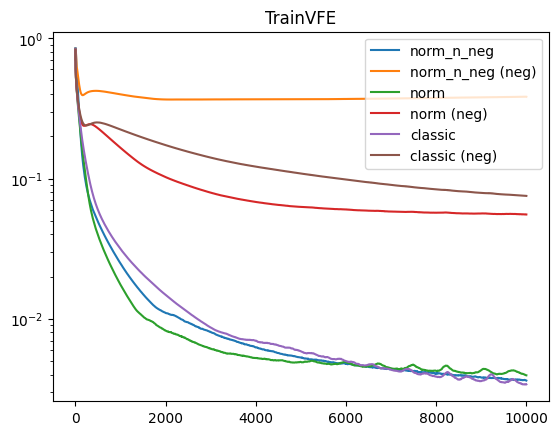

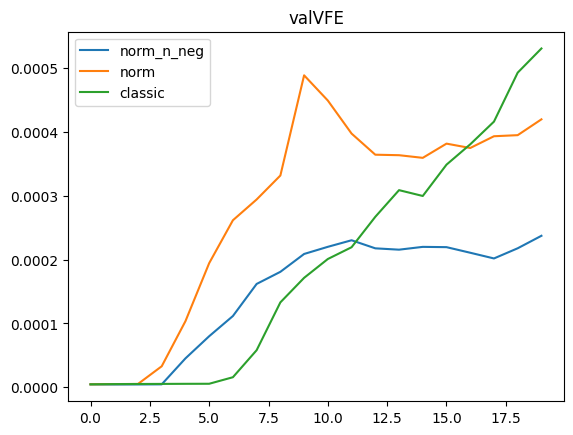

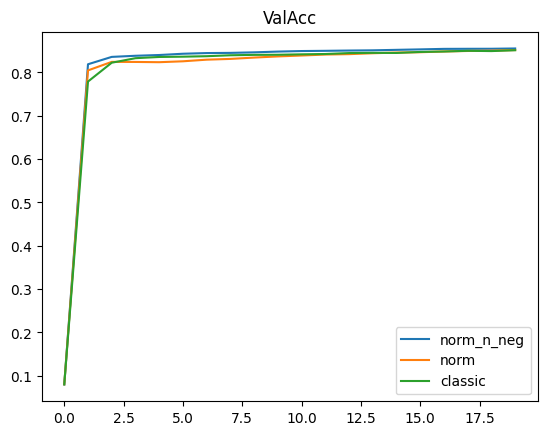

In [33]:
for k, v in all_stats.items():
    plt.plot(v['trainVfe'], label=k)
    plt.plot(v['negVfe'], label=k+' (neg)')
plt.legend()
plt.yscale('log')
plt.title('TrainVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valVfe'], label=k)
plt.legend()
plt.title('valVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valAcc'], label=k)
plt.legend()
plt.title('ValAcc')
# plt.yscale('log')
plt.show()